In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.grid_search import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from data_reader import read_data
from data_preprocessing import preprocess_data
from feature_extractor import extract_features

pd.set_option('display.max_colwidth', -1)
pd.set_option('mode.sim_interactive', True)
pd.set_option('expand_frame_repr', False)
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

%matplotlib inline

### Обработка данных

In [3]:
data = read_data()
print(data.shape)
data = preprocess_data(data)
data.head()

(258358, 19)


,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0100600000117000001,"Закупки товаров, работ, услуг в соответствии с п. 29 ч. 1 ст.93 Федерального закона",https://zakupki.kontur.ru/0100600000117000001,2017-04-13,"Закупка у единственного поставщика (подрядчика, исполнителя)",1310000.0,1310000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ КОПОРСКОЕ СЕЛЬСКОЕ ПОСЕЛЕНИЕ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ЛОМОНОСОВСКИЙ МУНИЦИПАЛЬНЫЙ РАЙОН ЛЕНИНГРАДСКОЙ ОБЛАСТИ,1024702184451,0.0,47
1,0100600000117000002,"Закупки товаров, работ, услуг в соответствии с п. 29 ч. 1 ст.93 Федерального закона",https://zakupki.kontur.ru/0100600000117000002,2017-04-13,"Закупка у единственного поставщика (подрядчика, исполнителя)",249000.0,249000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ КОПОРСКОЕ СЕЛЬСКОЕ ПОСЕЛЕНИЕ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ЛОМОНОСОВСКИЙ МУНИЦИПАЛЬНЫЙ РАЙОН ЛЕНИНГРАДСКОЙ ОБЛАСТИ,1024702184451,0.0,47
2,0100600000117000003,"Закупки товаров, работ, услуг в соответствии с п. 29 ч. 1 ст.93 Федерального закона",https://zakupki.kontur.ru/0100600000117000003,2017-07-06,"Закупка у единственного поставщика (подрядчика, исполнителя)",250000.0,250000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ КОПОРСКОЕ СЕЛЬСКОЕ ПОСЕЛЕНИЕ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ЛОМОНОСОВСКИЙ МУНИЦИПАЛЬНЫЙ РАЙОН ЛЕНИНГРАДСКОЙ ОБЛАСТИ,1024702184451,0.0,47
3,0100600000117000004,Выполнение работ по ремонту автомобильной дороги общего пользования местного значения в д.Климотино,https://zakupki.kontur.ru/0100600000117000004,2017-07-06,Запрос котировок,400300.0,400300.0,RUB,Размещение завершено,2.0,2.0,1.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ КОПОРСКОЕ СЕЛЬСКОЕ ПОСЕЛЕНИЕ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ЛОМОНОСОВСКИЙ МУНИЦИПАЛЬНЫЙ РАЙОН ЛЕНИНГРАДСКОЙ ОБЛАСТИ,1024702184451,1.0,47
4,0100600000117000005,Приобретение и установка спортивного оборудования,https://zakupki.kontur.ru/0100600000117000005,2017-07-10,Запрос котировок,451000.0,451000.0,RUB,Размещение завершено,2.0,1.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ КОПОРСКОЕ СЕЛЬСКОЕ ПОСЕЛЕНИЕ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ЛОМОНОСОВСКИЙ МУНИЦИПАЛЬНЫЙ РАЙОН ЛЕНИНГРАДСКОЙ ОБЛАСТИ,1024702184451,0.0,47


In [4]:
data.groupby('ProcedureDisplayName').size().reset_index()

,ProcedureDisplayName,0
0,Двухэтапный конкурс,2
1,Закрытый аукцион,20
2,Закрытый конкурс,13
3,"Закупка у единственного поставщика (подрядчика, исполнителя)",37448
4,"Закупка у единственного поставщика (подрядчика, исполнителя) с учетом положений ст. 111 Закона № 44-ФЗ",20
5,Запрос котировок,15475
6,"Запрос котировок на выполнение работ по строительству, реконструкции, капитальному ремонту, а также проектных, изыскательских работ в отношении олимпийских объектов и строительству домов взамен земельных участков и объектов недвижимого имущества, изымаемых",4
7,Запрос котировок с учетом положений ст. 111 Закона № 44-ФЗ,6
8,Запрос предложений,726
9,Конкурс для заключения энергосервисного контракта,17


In [5]:
data.groupby('ResultClass').size()

ResultClass
0.0    118170
1.0    133155
2.0    3464  
dtype: int64

In [6]:
data.drop(['StatusCode', 'SuppliersCount', 'IsWinner'], axis=1).corr()

,Amount,RubPrice,ResultClass,Ogrn1
Amount,1.000000,1.000000,0.075788,0.075294
RubPrice,1.000000,1.000000,0.075788,0.075294
ResultClass,0.075788,0.075788,1.000000,0.261333
Ogrn1,0.075294,0.075294,0.261333,1.000000


In [7]:
data_head = data
features = extract_features(data_head)[0]

oh CurrencyCode
oh ProcedureDisplayName
oh Ogrn
ng Title
ng OrgName


In [8]:
features = pd.DataFrame(features)

In [69]:
features.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features.drop('ResultClass', axis=1).values,
                            features.ResultClass.values,
                            test_size=0.3,
                            random_state=123456)

### Кросс-валидация и GridSearch

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X=X_train, y=y_train)
np.mean(cross_val_score(clf, X_train, y_train, scoring='accuracy'))

0.9360422095301558

In [11]:
rf = RF(n_estimators=100, n_jobs=-1)
rf = rf.fit(X_train, y_train)
np.mean(cross_val_score(rf, X_train, y_train, scoring='accuracy'))

0.9429106608510237

In [12]:
def grid_search(model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=10,  n_jobs=3, scoring='accuracy')
    gs.fit(X_train, y_train)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.best_estimator_

In [14]:
param_grid = { 
    'max_features': ['auto', 'log2'],
    'max_depth' : [8, 10, 12],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [4, 6, 8]
}

rf = grid_search(RF(n_estimators=100), param_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 10.9min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 14.8min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 18.0min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 24.5min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 33.1min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 38.5min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 45.4min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 51.6min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 54.7min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 59.3min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 62.3min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed: 124.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 131.7min
[Parallel(n_jobs=3)]: Done 175 tasks      | elapsed: 141.0min
[Parallel(n_jobs=3)]:

0.9214586884363506
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 4}


In [13]:
rf = RF(n_estimators=500, criterion='entropy', max_depth=12, max_features='auto', min_samples_leaf=4)
np.mean(cross_val_score(rf, X_train, y_train, scoring='accuracy'))

0.9227426689980996

In [17]:
param_grid = { 
    'learning_rate': [0.1, 0.01],
    'min_data_in_leaf': [9, 11, 13],
    'max_depth': [8, 10, 12],
    'num_iteration': [50, 75, 100]
}

gbm = grid_search(lgb.LGBMClassifier(objective='multiclass', metric='multi_error', num_classes=3, 
                                     feature_fraction=0.9, bagging_fraction=0.9,
                                    feature_fraction_seed=123456, bagging_freq=1, bagging_seed=123456), param_grid)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  8.3min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 15.5min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 20.0min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 24.5min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 29.8min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 35.4min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 41.6min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 48.8min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 55.8min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed: 62.9min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 70.3min
[Parallel(n_jobs=3)]: Done 175 tasks      | elapsed: 79.0min
[Parallel(n_jobs=3)]: Do

0.9459383690679106
{'learning_rate': 0.1, 'max_depth': 12, 'min_data_in_leaf': 13, 'num_iteration': 100}


In [14]:
gbm = lgb.LGBMClassifier(objective='multiclass', metric='multi_error', num_classes=3, learning_rate=0.1,
                            feature_fraction=0.9, bagging_fraction=0.9, max_depth=12, min_data_in_leaf=13,
                            feature_fraction_seed=123456, bagging_freq=1, bagging_seed=123456, num_iteration=100)
np.mean(cross_val_score(gbm, X_train, y_train, scoring='accuracy'))

0.9456916642707064

In [15]:
param_grid = {
    'max_depth': [10, 12],
    'min_child_weight': [9, 11],
    'colsample_bytree': [0.7, 0.9]
}

xgb = grid_search(XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=50, seed=123456, learning_rate=0.1, subsample=0.9), param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 24.7min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 70.7min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 97.4min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 171.0min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 229.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 320.0min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 374.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 374.4min finished


0.9504575222032834
{'colsample_bytree': 0.7, 'max_depth': 12, 'min_child_weight': 9}


### Тестовые данные

In [16]:
def get_metric(X_test, y_test, model):
    y_pred = None
    if "predict_proba" in dir(model):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
    test = pd.DataFrame(y_test, columns=['test'])
    test['prediction'] = [np.argmax(x) for x in y_pred]
    print(classification_report(y_test, test['prediction'].values))
    test['is_same'] = test.apply(lambda row: int(row[0] == row[1]), axis=1)
    f = {'is_same': ['sum', 'size', 'mean']}
    groups = test.groupby('test').agg(f)
    print(sum(test['is_same']) / test.shape[0])
    return groups['is_same'].sort_values('mean', ascending=False)

In [17]:
def transform_to_one_vs_rest(y_test, y_pred_proba, index):
    y_test_i = np.array(list(map(lambda e: 1 if e == index else 0, y_test)))
    y_pred_proba_i = np.array(list(map(lambda probas: probas[index], y_pred_proba)))
    return y_test_i, y_pred_proba_i

In [66]:
def get_roc_auc(X_test, y_test, model):
    y_pred = None
    if "predict_proba" in dir(model):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    titles = ['Неуспех', 'Успех', 'Отмена']
    for i in range(3):
        y_test_i, y_pred_i = transform_to_one_vs_rest(y_test, y_pred, i)
        fpr, tpr, _ = roc_curve(y_test_i,  y_pred_i)
        auc = roc_auc_score(y_test_i, y_pred_i)
        axes[i].plot(fpr, tpr, label=f'class {i}, auc={auc}')
        axes[i].legend(loc=4)
        axes[i].set_title(titles[i])
    plt.show()

In [72]:
gbm.fit(X_train, y_train)
get_metric(X_test, y_test, gbm)

             precision    recall  f1-score   support

        0.0       0.97      0.91      0.94     35346
        1.0       0.93      0.99      0.96     40025
        2.0       0.85      0.56      0.68      1066

avg / total       0.95      0.95      0.95     76437

0.9464526341954812


,sum,size,mean
test,,,
1.0,39576,40025,0.988782
0.0,32169,35346,0.910117
2.0,599,1066,0.561914


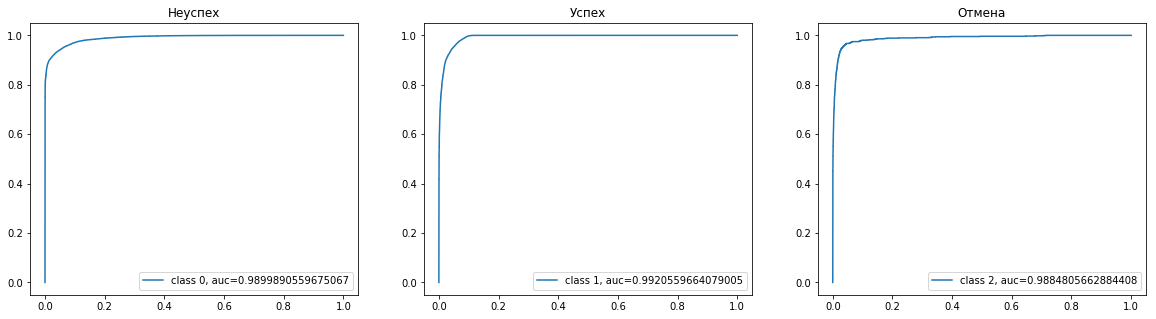

In [73]:
get_roc_auc(X_test, y_test, gbm)

In [75]:
xgb.fit(X_train, y_train)
get_metric(X_test, y_test, xgb)

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95     35346
        1.0       0.94      0.98      0.96     40025
        2.0       0.90      0.50      0.65      1066

avg / total       0.95      0.95      0.95     76437

0.9512278085220508


,sum,size,mean
test,,,
1.0,39424,40025,0.984984
0.0,32747,35346,0.926470
2.0,538,1066,0.504690


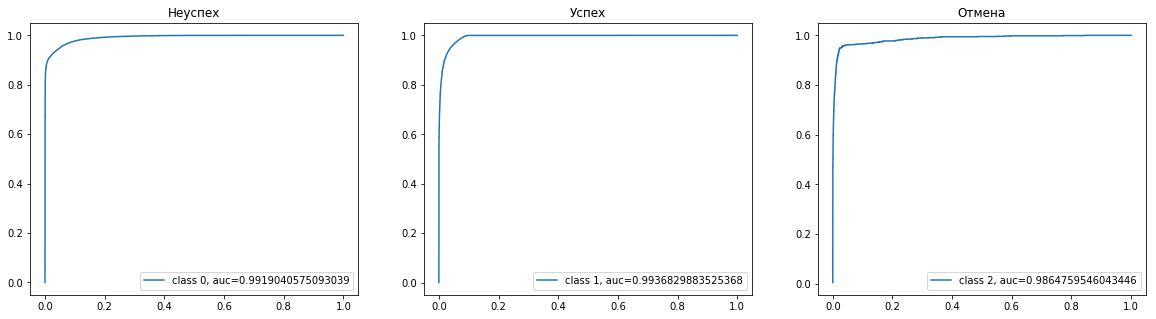

In [76]:
get_roc_auc(X_test, y_test, xgb)

In [77]:
rf.fit(X_train, y_train)
get_metric(X_test, y_test, rf)

             precision    recall  f1-score   support

        0.0       0.97      0.87      0.91     35346
        1.0       0.89      0.99      0.94     40025
        2.0       1.00      0.32      0.48      1066

avg / total       0.93      0.92      0.92     76437

0.9249970563993878


,sum,size,mean
test,,,
1.0,39774,40025,0.993729
0.0,30589,35346,0.865416
2.0,341,1066,0.319887


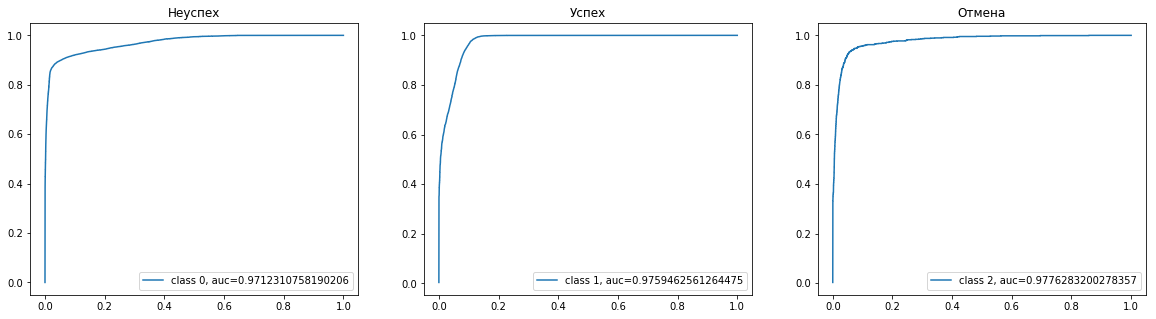

In [78]:
get_roc_auc(X_test, y_test, rf)

In [80]:
clf.fit(X_train, y_train)
get_metric(X_test, y_test, clf)

             precision    recall  f1-score   support

        0.0       0.93      0.94      0.94     35346
        1.0       0.95      0.95      0.95     40025
        2.0       0.67      0.64      0.66      1066

avg / total       0.94      0.94      0.94     76437

0.9398328034852231


,sum,size,mean
test,,,
1.0,38046,40025,0.950556
0.0,33108,35346,0.936683
2.0,684,1066,0.641651


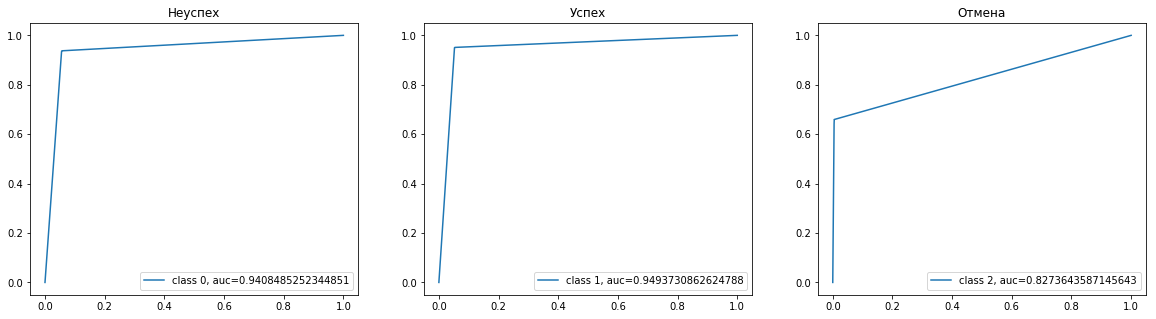

In [81]:
get_roc_auc(X_test, y_test, clf)

### CatBoost

Отдельная обработка, т.к. отдельно вычисляются категориальные признаки

In [28]:
features = extract_features(data_head, onehot_encode=False)[0]
features = pd.DataFrame(features)
features.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features.drop('ResultClass', axis=1).values,
                            features.ResultClass.values,
                            test_size=0.3,
                            random_state=123456)

ng Title
ng OrgName


In [29]:
cat_features = ['CurrencyCode', 'ProcedureDisplayName', 'Ogrn1']
features[cat_features].head()

,CurrencyCode,ProcedureDisplayName,Ogrn1
0,0,3,16
1,0,3,16
2,0,3,16
3,0,5,16
4,0,5,16


In [30]:
cats = np.where(features.dtypes != np.float)[0]
cats

array([4, 5, 6], dtype=int64)

In [31]:
model = CatBoostClassifier(iterations=100, depth=10, learning_rate=.1, loss_function='MultiClass', classes_count=3,
                           logging_level='Silent')
model.fit(X_train, y_train, cat_features=cats)

In [32]:
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.93     35346
        1.0       0.92      0.99      0.95     40025
        2.0       0.92      0.43      0.59      1066

avg / total       0.94      0.94      0.94     76437

0.9413373104648273


,sum,size,mean
test,,,
1.0,39537,40025,0.987808
0.0,31954,35346,0.904034
2.0,462,1066,0.433396


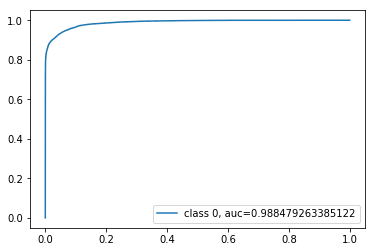

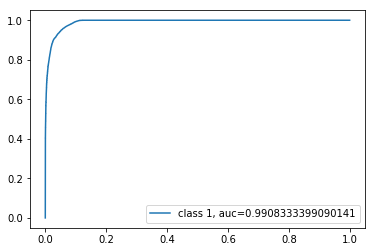

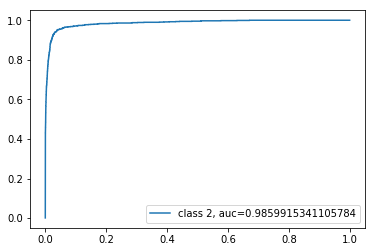

In [33]:
get_roc_auc(X_test, y_test, model)

In [55]:
def cross_val(X, y, X_test, param, cat_features, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    acc = []
    predict = None
    
    for tr_ind, val_ind in skf.split(X, y):
        X_train = X[tr_ind]
        y_train = y[tr_ind]
        
        X_valid = X[val_ind]
        y_valid = y[val_ind]
        
        clf = CatBoostClassifier(iterations=100, loss_function=param['loss_function'], depth=param['depth'],
                                 eval_metric='Accuracy', leaf_estimation_iterations=10,
                                 logging_level='Silent', learning_rate=param['learning_rate'],
                                 classes_count=3)
        
        clf.fit(X_train, 
                y_train,
                cat_features=cat_features
        )
        
        y_pred = clf.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        acc.append(accuracy)
    return sum(acc)/n_splits
    
def catboost_GridSearchCV(X, y, X_test, params, cat_features, n_splits=5):
    ps = {'acc':0,
          'param': []
    }
    
    predict=None
    grid = list(ParameterGrid(params))
    l = len(grid)
    for i, prms in enumerate(grid):
                          
        acc = cross_val(X, y, X_test, prms, cat_features, n_splits=5)
        print(f'{i}/{l}')
        if acc>ps['acc']:
            ps['acc'] = acc
            ps['param'] = prms
    print('Acc: '+str(ps['acc']))
    print('Params: '+str(ps['param']))
    
    return ps['param']

In [56]:
params = {
    'depth':[7, 9, 11],
    'loss_function': ['MultiClass', 'MultiClassOneVsAll'],
    'learning_rate': [0.1, 0.01]
}
    
param = catboost_GridSearchCV(X_train, y_train, X_test, params, cats)
param

0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
Acc: 0.9462187237765359
Params: {'depth': 11, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}


{'depth': 11, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}

In [57]:
model = CatBoostClassifier(iterations=500, depth=11, learning_rate=.1, loss_function='MultiClass', classes_count=3,
                           logging_level='Silent', leaf_estimation_iterations=10)
model.fit(X_train, y_train, cat_features=cats)

In [58]:
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95     35346
        1.0       0.94      0.98      0.96     40025
        2.0       0.90      0.55      0.68      1066

avg / total       0.95      0.95      0.95     76437

0.9534387796485995


,sum,size,mean
test,,,
1.0,39328,40025,0.982586
0.0,32965,35346,0.932637
2.0,585,1066,0.548780


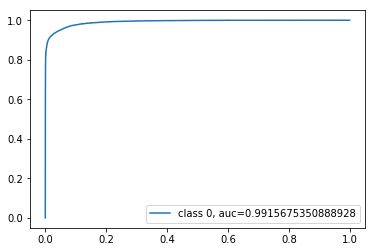

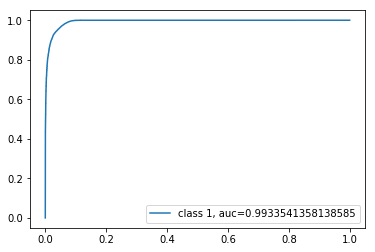

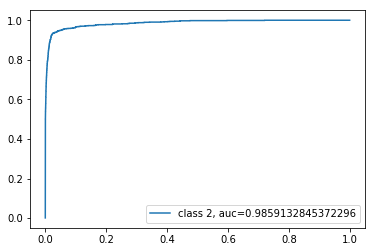

In [59]:
get_roc_auc(X_test, y_test, model)

In [82]:
model = CatBoostClassifier(iterations=1000, depth=11, learning_rate=.1, loss_function='MultiClass', 
                           classes_count=3, logging_level='Silent', leaf_estimation_iterations=10)
model.fit(X_train, y_train, cat_features=cats)
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95     35346
        1.0       0.95      0.98      0.96     40025
        2.0       0.88      0.55      0.68      1066

avg / total       0.95      0.95      0.95     76437

0.9531902089302301


,sum,size,mean
test,,,
1.0,39205,40025,0.979513
0.0,33067,35346,0.935523
2.0,587,1066,0.550657


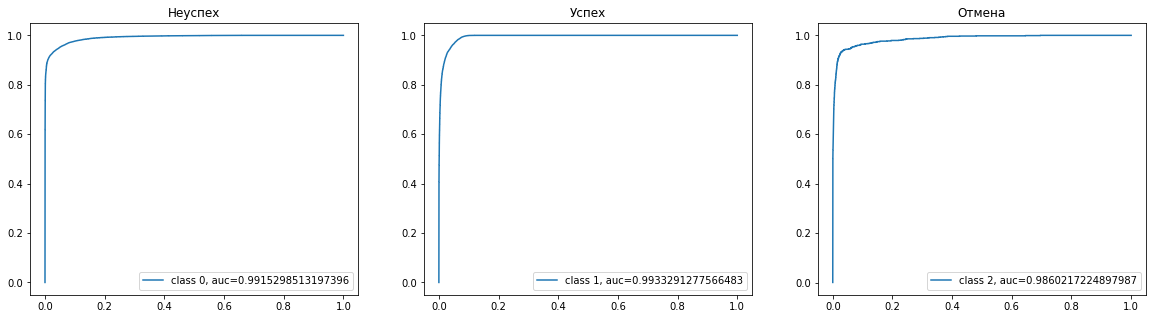

In [83]:
get_roc_auc(X_test, y_test, model)

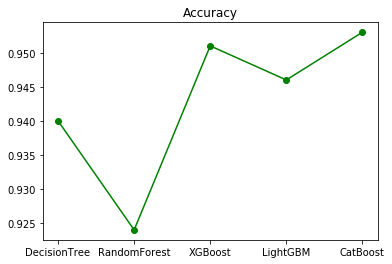

In [86]:
x = ['DecisionTree', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
plt.title('Accuracy')
y = [0.94, 0.924, 0.951, 0.946, 0.953]
plt.plot(x, y, 'go-')